Step 1: Import Required Libraries

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

# Set up plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")


Step 2: Load and Prepare the Data

In [133]:
# Load all datasets
transmission_df = pd.read_csv("transmission_network.csv")
generation_df = pd.read_csv("source_generation.csv")
demand_df = pd.read_csv("node_demand.csv")
cost_df = pd.read_csv("cost_data.csv")

# Preprocess data
sources = cost_df['Source'].unique()
nodes = [col for col in demand_df.columns if col != 'Hour']
hours = demand_df['Hour'].unique()

# Create a combined dataset for easier processing
def prepare_hourly_data(hour):
    hourly_data = {
        'generation': generation_df[generation_df['Hour'] == hour].iloc[0],
        'demand': demand_df[demand_df['Hour'] == hour].iloc[0],
        'transmission': transmission_df,
        'cost': cost_df
    }
    return hourly_data

Step 3: Define Genetic Algorithm Parameters

In [134]:
# Add peak hours definition and adjust penalty constants
PEAK_HOURS = range(17, 21)  # 5PM-9PM (17:00-20:59)
PENALTY_CAP_SOURCE = 50      # +50 penalty per kW over source capacity
PENALTY_CAP_NODE = 10        # +10 penalty per kW unmet demand
PENALTY_CAP_LINE = 10        # +10 penalty per kW over line capacity
PEAK_COST_MULTIPLIER = 1.5   # 1.5x cost during peak hours

Step 4: Define Chromosome Structure and Initialization

In [135]:
def initialize_population(n_sources, n_nodes):
    """Creates initial population of random chromosomes"""
    population = []
    for _ in range(POPULATION_SIZE):
        # Chromosome is a matrix where rows are sources and columns are nodes
        chromosome = np.random.rand(n_sources, n_nodes) * 100
        population.append(chromosome)
    return population

Step 5: Fitness Function Calculation

In [136]:
def calculate_fitness(chromosome, hourly_data):
    """Calculates fitness score for a chromosome according to specified format"""
    n_sources, n_nodes = chromosome.shape

    # Extract data for the hour
    generation = hourly_data['generation']
    demand = hourly_data['demand']
    transmission = hourly_data['transmission']
    cost_data = hourly_data['cost']

    # Base score (as specified)
    BASE_SCORE = 10000
    fitness = BASE_SCORE

    # Calculate total demand for each node (excluding Hour column)
    demands = np.array([demand[f'Node_{i+1}'] for i in range(n_nodes)])

    # Get generation capacities for this hour
    source_capacities = np.array([
        generation['Solar'],
        generation['Wind'],
        generation['Hydro']
    ])

    # Calculate costs and loss rates
    source_costs = cost_data['Generation_Cost_per_kWh'].values
    transmission_costs = cost_data['Transmission_Cost_per_kWh_km'].values

    # Calculate loss rates between sources and nodes
    loss_rates = np.zeros((n_sources, n_nodes))
    for i, source in enumerate(sources):
        for j in range(n_nodes):
            node = f'Node_{j+1}'
            # Find transmission data for this source-node pair
            trans_data = transmission[(transmission['From'] == source) &
                                     (transmission['To'] == node)]
            if not trans_data.empty:
                loss_rates[i, j] = trans_data['Loss_Percent'].values[0] / 100

    # Calculate total generation cost (in $)
    generation_cost = np.sum(chromosome * source_costs[:, np.newaxis])

    # Calculate total transmission cost (in $)
    transmission_cost = np.sum(chromosome * transmission_costs[:, np.newaxis] *
                         transmission_df.groupby(['From', 'To'])['Distance_km'].first().unstack().values)

    # Total cost component (subtract from fitness)
    total_cost = generation_cost + transmission_cost
    fitness -= total_cost

    # Calculate total loss (in kW) and subtract from fitness
    total_loss = np.sum(chromosome * loss_rates)
    fitness -= total_loss

    # Calculate penalties
    total_penalty = 0

    # 1. Penalty for exceeding source capacities
    supplied_from_sources = np.sum(chromosome, axis=1)
    source_violations = np.maximum(0, supplied_from_sources - source_capacities)
    source_penalty = np.sum(source_violations) * 1  # $1 per kW violation
    total_penalty += source_penalty

    # 2. Penalty for exceeding node capacities (assuming capacity is 1.5x demand)
    supplied_to_nodes = np.sum(chromosome, axis=0)
    node_violations = np.maximum(0, supplied_to_nodes - demands * 1.5)
    node_penalty = np.sum(node_violations) * 1  # $1 per kW violation
    total_penalty += node_penalty

    # 3. Penalty for negative energy allocation
    neg_violations = np.sum(np.maximum(0, -chromosome))
    neg_penalty = neg_violations * 1000  # Large penalty for negative values
    total_penalty += neg_penalty

    # 4. Penalty for unmet demand
    unmet_demand = np.maximum(0, demands - supplied_to_nodes)
    demand_penalty = np.sum(unmet_demand) * 2  # $2 per kW of unmet demand
    total_penalty += demand_penalty

    # Subtract total penalty from fitness
    fitness -= total_penalty

    return fitness

Step 6: Genetic Operators

Parallel Tournament Selection

In [137]:
def tournament_selection(args):
    population, fitness_scores = args
    idx1, idx2 = np.random.choice(len(population), size=2, replace=False)
    return population[idx1] if fitness_scores[idx1] < fitness_scores[idx2] else population[idx2]

def selection_parallel(population, fitness_scores):
    with Pool(N_CORES) as pool:
        args = [(population, fitness_scores)] * len(population)
        selected_parents = pool.map(tournament_selection, args)
    return selected_parents

Parallel Crossover (Single-point)

In [138]:
def crossover_pair(args):
    parent1, parent2 = args
    if np.random.rand() < CROSSOVER_RATE:
        crossover_point = np.random.randint(1, parent1.size)
        child1 = np.concatenate(
            (parent1.flatten()[:crossover_point],
             parent2.flatten()[crossover_point:])
        ).reshape(parent1.shape)
        child2 = np.concatenate(
            (parent2.flatten()[:crossover_point],
             parent1.flatten()[crossover_point:])
        ).reshape(parent1.shape)
        return [child1, child2]
    else:
        return [parent1, parent2]

def crossover_parallel(parents):
    pair_args = [(parents[i], parents[i+1] if i+1 < len(parents) else parents[0]) for i in range(0, len(parents), 2)]
    with Pool(N_CORES) as pool:
        offspring_nested = pool.map(crossover_pair, pair_args)
    # Flatten the nested offspring list
    offspring = [child for pair in offspring_nested for child in pair]
    return offspring

Parallel Mutation

In [139]:
def crossover_pair(args):
    parent1, parent2 = args
    if np.random.rand() < CROSSOVER_RATE:
        crossover_point = np.random.randint(1, parent1.size)
        child1 = np.concatenate(
            (parent1.flatten()[:crossover_point],
             parent2.flatten()[crossover_point:])
        ).reshape(parent1.shape)
        child2 = np.concatenate(
            (parent2.flatten()[:crossover_point],
             parent1.flatten()[crossover_point:])
        ).reshape(parent1.shape)
        return [child1, child2]
    else:
        return [parent1, parent2]

def crossover_parallel(parents):
    pair_args = [(parents[i], parents[i+1] if i+1 < len(parents) else parents[0]) for i in range(0, len(parents), 2)]
    with Pool(N_CORES) as pool:
        offspring_nested = pool.map(crossover_pair, pair_args)
    # Flatten the nested offspring list
    offspring = [child for pair in offspring_nested for child in pair]
    return offspring


In [140]:
# def selection(population, fitness_scores):
#     """Tournament selection"""
#     selected_parents = []
#     for _ in range(len(population)):
#         # Randomly select 2 individuals
#         idx1, idx2 = np.random.choice(len(population), size=2, replace=False)
#         # Choose the one with better fitness
#         if fitness_scores[idx1] < fitness_scores[idx2]:
#             selected_parents.append(population[idx1])
#         else:
#             selected_parents.append(population[idx2])
#     return selected_parents

# def crossover(parents):
#     """Single-point crossover"""
#     offspring = []
#     for i in range(0, len(parents), 2):
#         parent1 = parents[i]
#         parent2 = parents[i+1] if i+1 < len(parents) else parents[0]

#         if np.random.rand() < CROSSOVER_RATE:
#             # Perform crossover
#             crossover_point = np.random.randint(1, parent1.size)
#             child1 = np.concatenate(
#                 (parent1.flatten()[:crossover_point],
#                  parent2.flatten()[crossover_point:])
#             ).reshape(parent1.shape)
#             child2 = np.concatenate(
#                 (parent2.flatten()[:crossover_point],
#                  parent1.flatten()[crossover_point:])
#             ).reshape(parent1.shape)
#             offspring.append(child1)
#             offspring.append(child2)
#         else:
#             # No crossover, parents become offspring
#             offspring.append(parent1)
#             offspring.append(parent2)
#     return offspring

# def mutation(offspring):
#     """Random mutation"""
#     for i in range(len(offspring)):
#         if np.random.rand() < MUTATION_RATE:
#             mutation_point = np.random.randint(0, offspring[i].size)
#             row = mutation_point // offspring[i].shape[1]
#             col = mutation_point % offspring[i].shape[1]
#             # Ensure allocation remains non-negative
#             offspring[i][row, col] = max(0, offspring[i][row, col] + np.random.normal(0, 10))
#     return offspring

In [141]:
# def selection(population, fitness_scores):
#     """Select parents for reproduction using tournament selection"""
#     selected = []
#     for _ in range(len(population)):
#         # Tournament selection
#         candidates = np.random.choice(len(population), size=2)
#         winner = candidates[0] if fitness_scores[candidates[0]] > fitness_scores[candidates[1]] else candidates[1]
#         selected.append(population[winner])
#     return selected

# def crossover(parents):
#     """Perform crossover between parents to produce offspring"""
#     offspring = []
#     for i in range(0, len(parents), 2):
#         parent1, parent2 = parents[i], parents[i+1]
#         child1 = parent1.copy()
#         child2 = parent2.copy()
#         # Perform crossover (example: single point crossover)
#         crossover_point = np.random.randint(1, len(parent1))
#         child1[crossover_point:] = parent2[crossover_point:]
#         child2[crossover_point:] = parent1[crossover_point:]
#         offspring.extend([child1, child2])
#     return offspring

# def mutation(offspring):
#     """Perform mutation on offspring"""
#     for i in range(len(offspring)):
#         if np.random.rand() < MUTATION_RATE:  # MUTATION_RATE should be defined
#             mutation_point = np.random.randint(len(offspring[i]))
#             offspring[i][mutation_point] = np.random.rand()  # Example mutation
#     return offspring

Step 7: Parallel Evaluation Function

In [142]:
def evaluate_population_parallel(population, hourly_data):
    """Evaluates population fitness in parallel"""
    with Pool(N_CORES) as p:
        # Create list of (chromosome, hourly_data) tuples
        args = [(chromo, hourly_data) for chromo in population]
        fitness_scores = p.starmap(calculate_fitness, args)
    return fitness_scores

def evaluate_population_serial(population, hourly_data):
    """Evaluates population fitness serially"""
    return [calculate_fitness(chromo, hourly_data) for chromo in population]

Step 8: Main GA Function

In [143]:
def run_ga_for_hour(hour, parallel=True):
    """Runs GA for a specific hour"""
    hourly_data = prepare_hourly_data(hour)
    n_sources = len(sources)
    n_nodes = len(nodes)

    population = initialize_population(n_sources, n_nodes)
    best_fitness_history = []
    avg_fitness_history = []

    for generation in range(N_GENERATIONS):
        # Evaluate population
        if parallel:
            fitness_scores = evaluate_population_parallel(population, hourly_data)
        else:
            fitness_scores = evaluate_population_serial(population, hourly_data)

        # Track best and average fitness
        best_fitness = np.min(fitness_scores)
        avg_fitness = np.mean(fitness_scores)
        best_fitness_history.append(best_fitness)
        avg_fitness_history.append(avg_fitness)

        # Genetic operations
        parents = selection(population, fitness_scores)
        offspring = crossover(parents)
        mutated_offspring = mutation(offspring)

        # Elitism: keep best solution from previous generation
        best_idx = np.argmin(fitness_scores)
        population = [population[best_idx]] + mutated_offspring[:-1]

    # Final evaluation
    final_fitness = evaluate_population_serial(population, hourly_data)
    best_idx = np.argmin(final_fitness)
    best_solution = population[best_idx]
    best_fitness = final_fitness[best_idx]

    return best_solution, best_fitness, best_fitness_history, avg_fitness_history

Step 9: Greedy Algorithm for Comparison

In [144]:
def run_greedy_for_hour(hour):
    """Greedy algorithm for comparison"""
    hourly_data = prepare_hourly_data(hour)
    n_sources = len(sources)
    n_nodes = len(nodes)

    chromosome = np.zeros((n_sources, n_nodes))
    demands = np.array([hourly_data['demand'][f'Node_{i+1}'] for i in range(n_nodes)])
    source_capacities = np.array([
        hourly_data['generation']['Solar'],
        hourly_data['generation']['Wind'],
        hourly_data['generation']['Hydro']
    ])

    # Sort sources by cost (cheapest first)
    costs = cost_df['Generation_Cost_per_kWh'].values
    sorted_sources = np.argsort(costs)

    for j in range(n_nodes):
        remaining_demand = demands[j]
        for i in sorted_sources:
            # Check source capacity
            used_capacity = np.sum(chromosome[i, :])
            available = source_capacities[i] - used_capacity

            # Allocate as much as possible
            allocation = min(remaining_demand, available)
            if allocation > 0:
                chromosome[i, j] = allocation
                remaining_demand -= allocation

            if remaining_demand <= 0:
                break

    fitness = calculate_fitness(chromosome, hourly_data)
    return chromosome, fitness

Step 10: Run and Compare Algorithms

In [145]:
def run_comparison(hour=0):
    """Runs and compares serial GA, parallel GA, and greedy algorithm"""
    print(f"Running algorithms for hour {hour}...")

    # Run Serial GA
    start_time = time.time()
    best_serial, fit_serial, hist_serial, avg_serial = run_ga_for_hour(hour, parallel=False)
    serial_time = time.time() - start_time

    # Run Parallel GA
    start_time = time.time()
    best_parallel, fit_parallel, hist_parallel, avg_parallel = run_ga_for_hour(hour, parallel=True)
    parallel_time = time.time() - start_time

    # Run Greedy
    start_time = time.time()
    best_greedy, fit_greedy = run_greedy_for_hour(hour)
    greedy_time = time.time() - start_time

    # Print results
    print(f"\nResults for hour {hour}:")
    print(f"Serial GA - Fitness: {fit_serial:.2f}, Time: {serial_time:.2f}s")
    print(f"Parallel GA - Fitness: {fit_parallel:.2f}, Time: {parallel_time:.2f}s")
    print(f"Greedy - Fitness: {fit_greedy:.2f}, Time: {greedy_time:.2f}s")

    # Plot convergence
    plt.figure(figsize=(10, 6))
    plt.plot(hist_serial, label='Serial GA (Best)')
    plt.plot(avg_serial, label='Serial GA (Avg)', alpha=0.7)
    plt.plot(hist_parallel, label='Parallel GA (Best)')
    plt.plot(avg_parallel, label='Parallel GA (Avg)', alpha=0.7)
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score')
    plt.title('GA Convergence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Plot execution times
    plt.figure(figsize=(8, 5))
    algorithms = ['Serial GA', 'Parallel GA', 'Greedy']
    times = [serial_time, parallel_time, greedy_time]
    plt.bar(algorithms, times, color=['blue', 'green', 'red'], alpha=0.7)
    plt.ylabel('Execution Time (s)')
    plt.title('Algorithm Execution Time Comparison')
    plt.show()

    # Plot fitness comparison
    plt.figure(figsize=(8, 5))
    fitness_values = [fit_serial, fit_parallel, fit_greedy]
    plt.bar(algorithms, fitness_values, color=['blue', 'green', 'red'], alpha=0.7)
    plt.ylabel('Fitness Score')
    plt.title('Final Fitness Comparison')
    plt.show()

    return {
        'serial': {'solution': best_serial, 'fitness': fit_serial, 'time': serial_time},
        'parallel': {'solution': best_parallel, 'fitness': fit_parallel, 'time': parallel_time},
        'greedy': {'solution': best_greedy, 'fitness': fit_greedy, 'time': greedy_time}
    }

Step 11: Execute the Comparison

Running algorithms for hour 0...

Results for hour 0:
Serial GA - Fitness: 6317.78, Time: 82.86s
Parallel GA - Fitness: 5743.01, Time: 108.92s
Greedy - Fitness: 9647.03, Time: 0.01s


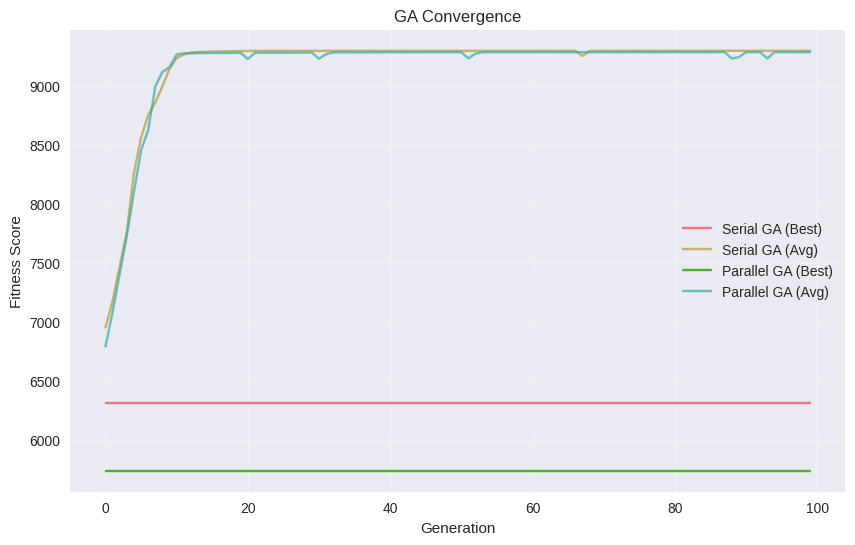

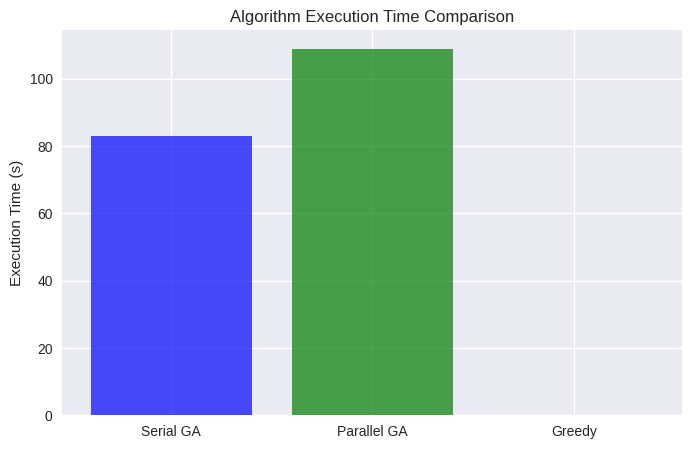

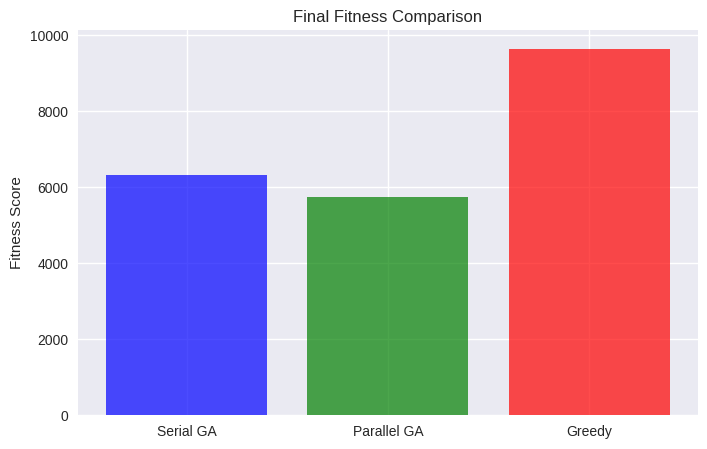


Best energy allocation matrix from Parallel GA:
       Node_1  Node_2  Node_3  Node_4  Node_5  Node_6  Node_7  Node_8  Node_9  \
Solar   10.26   90.94   73.41   83.89   38.57   81.91   98.31   25.84   58.67   
Wind    14.41   92.58   84.59   66.40    4.79   94.76   65.60   56.14   38.02   
Hydro   85.13   97.25   73.12   96.60   88.39   89.22   47.76   64.71   28.47   

       Node_10  
Solar    89.68  
Wind     67.33  
Hydro    11.20  

Parallelization Metrics:
Speedup: 0.76x
Efficiency: 19.02%


In [146]:
if __name__ == "__main__":
    # Run comparison for hour 0 (can be changed to any hour 0-23)
    results = run_comparison(hour=0)

    # Display the best allocation matrix from parallel GA
    print("\nBest energy allocation matrix from Parallel GA:")
    allocation_df = pd.DataFrame(
        results['parallel']['solution'],
        index=sources,
        columns=nodes
    )
    print(allocation_df.round(2))

    # Calculate speedup and efficiency
    speedup = results['serial']['time'] / results['parallel']['time']
    efficiency = (speedup / N_CORES) * 100
    print(f"\nParallelization Metrics:")
    print(f"Speedup: {speedup:.2f}x")
    print(f"Efficiency: {efficiency:.2f}%")

Plot convergence curves, resource usage (CPU/GPU), and runtime statistics

In [147]:
import psutil
import timeit
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count
import os

In [148]:
# Set up plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

In [149]:
class ResourceMonitor:
    """Class to monitor CPU and memory usage during execution"""
    def __init__(self):
        self.cpu_percents = []
        self.memory_usages = []
        self.timestamps = []
        self.start_time = timeit.default_timer()

    def record(self):
        """Record current resource usage"""
        self.cpu_percents.append(psutil.cpu_percent())
        self.memory_usages.append(psutil.virtual_memory().percent)
        self.timestamps.append(timeit.default_timer() - self.start_time)

    def get_stats(self):
        """Return statistics about resource usage"""
        return {
            'max_cpu': max(self.cpu_percents),
            'avg_cpu': np.mean(self.cpu_percents),
            'max_memory': max(self.memory_usages),
            'avg_memory': np.mean(self.memory_usages),
            'duration': self.timestamps[-1] if self.timestamps else 0
        }

In [150]:
def plot_convergence(histories, labels, title="GA Convergence"):
    """Plot convergence curves for multiple runs"""
    plt.figure(figsize=(12, 6))

    for history, label in zip(histories, labels):
        if isinstance(history, dict):
            # Handle dictionary format with best and avg fitness
            plt.plot(history['best'], label=f"{label} (Best)", linewidth=2)
            plt.plot(history['avg'], label=f"{label} (Average)", alpha=0.7, linestyle='--')
        else:
            # Handle simple list format
            plt.plot(history, label=label, linewidth=2)

    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Fitness Score', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

In [151]:
def plot_resource_usage(monitors, labels):
    """Plot CPU and memory usage over time"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    for monitor, label in zip(monitors, labels):
        if monitor.timestamps:
            ax1.plot(monitor.timestamps, monitor.cpu_percents, label=label)
            ax2.plot(monitor.timestamps, monitor.memory_usages, label=label)

    ax1.set_ylabel('CPU Usage (%)', fontsize=12)
    ax1.set_title('Resource Usage During Execution', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    ax2.set_xlabel('Time (seconds)', fontsize=12)
    ax2.set_ylabel('Memory Usage (%)', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [152]:
def plot_runtime_stats(times_dict, title="Runtime Comparison"):
    """Plot bar charts comparing runtime statistics"""
    times_df = pd.DataFrame.from_dict(times_dict, orient='index', columns=['Time (s)'])

    plt.figure(figsize=(10, 6))
    bars = plt.bar(times_df.index, times_df['Time (s)'], alpha=0.7)

    plt.ylabel('Time (seconds)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s',
                ha='center', va='bottom', fontsize=10)

    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

In [153]:
def plot_speedup_efficiency(serial_time, parallel_time, n_cores):
    """Plot speedup and efficiency metrics"""
    speedup = serial_time / parallel_time
    efficiency = (speedup / n_cores) * 100

    metrics = ['Speedup', f'Efficiency\n({n_cores} cores)']
    values = [speedup, efficiency]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e'], alpha=0.7)

    plt.ylabel('Value', fontsize=12)
    plt.title('Parallelization Performance', fontsize=14)

    # Add values on top of bars
    for bar, value in zip(bars, values):
        unit = 'x' if 'Speedup' in metrics[list(bars).index(bar)] else '%'
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.02,
                f'{value:.2f}{unit}',
                ha='center', va='bottom', fontsize=12)

    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

In [154]:
def plot_algorithm_comparison(results):
    """Compare all algorithms on multiple metrics"""
    metrics = ['Fitness', 'Runtime (s)']
    algorithms = list(results.keys())

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Fitness comparison
    fitness_values = [results[alg]['fitness'] for alg in algorithms]
    axes[0].bar(algorithms, fitness_values, alpha=0.7)
    axes[0].set_ylabel('Fitness Score', fontsize=12)
    axes[0].set_title('Algorithm Fitness Comparison', fontsize=14)
    axes[0].grid(True, alpha=0.3)

    # Runtime comparison
    runtime_values = [results[alg]['time'] for alg in algorithms]
    axes[1].bar(algorithms, runtime_values, alpha=0.7)
    axes[1].set_ylabel('Time (seconds)', fontsize=12)
    axes[1].set_title('Algorithm Runtime Comparison', fontsize=14)
    axes[1].grid(True, alpha=0.3)

    # Add values on top of bars
    for ax in axes:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 10),
                        textcoords='offset points',
                        fontsize=10)

    plt.tight_layout()
    plt.show()


In [155]:
# Modified GA function with resource monitoring
def run_ga_with_monitoring(hour, parallel=True):
    """Run GA with resource monitoring"""
    monitor = ResourceMonitor()
    hourly_data = prepare_hourly_data(hour)
    n_sources = len(sources)
    n_nodes = len(nodes)

    population = initialize_population(n_sources, n_nodes)
    best_fitness_history = []
    avg_fitness_history = []

    monitor.record()  # Initial recording

    for generation in range(N_GENERATIONS):
        # Evaluate population
        if parallel:
            fitness_scores = evaluate_population_parallel(population, hourly_data)
        else:
            fitness_scores = evaluate_population_serial(population, hourly_data)

        # Track fitness
        best_fitness_history.append(np.min(fitness_scores))
        avg_fitness_history.append(np.mean(fitness_scores))

        # Genetic operations
        parents = selection(population, fitness_scores)
        offspring = crossover(parents)
        mutated_offspring = mutation(offspring)

        # Elitism
        best_idx = np.argmin(fitness_scores)
        population = [population[best_idx]] + mutated_offspring[:-1]

        # Record resources every 5 generations
        if generation % 5 == 0:
            monitor.record()

    # Final evaluation and recording
    final_fitness = evaluate_population_serial(population, hourly_data)
    best_idx = np.argmin(final_fitness)
    best_solution = population[best_idx]
    best_fitness = final_fitness[best_idx]
    monitor.record()

    return {
        'solution': best_solution,
        'fitness': best_fitness,
        'history': {'best': best_fitness_history, 'avg': avg_fitness_history},
        'monitor': monitor
    }

Running comprehensive comparison for hour 0...

Running Serial GA...

Running Parallel GA...

Running Greedy Algorithm...

=== Algorithm Performance Summary ===

Serial GA:
  Fitness: 5968.24
  Runtime: 82.17s
  Max CPU: 81.6%
  Avg CPU: 62.2%
  Max Memory: 10.9%

Parallel GA:
  Fitness: 6121.58
  Runtime: 109.10s
  Max CPU: 99.8%
  Avg CPU: 94.5%
  Max Memory: 10.8%

Greedy:
  Fitness: 9647.03
  Runtime: 0.02s

Generating visualizations...


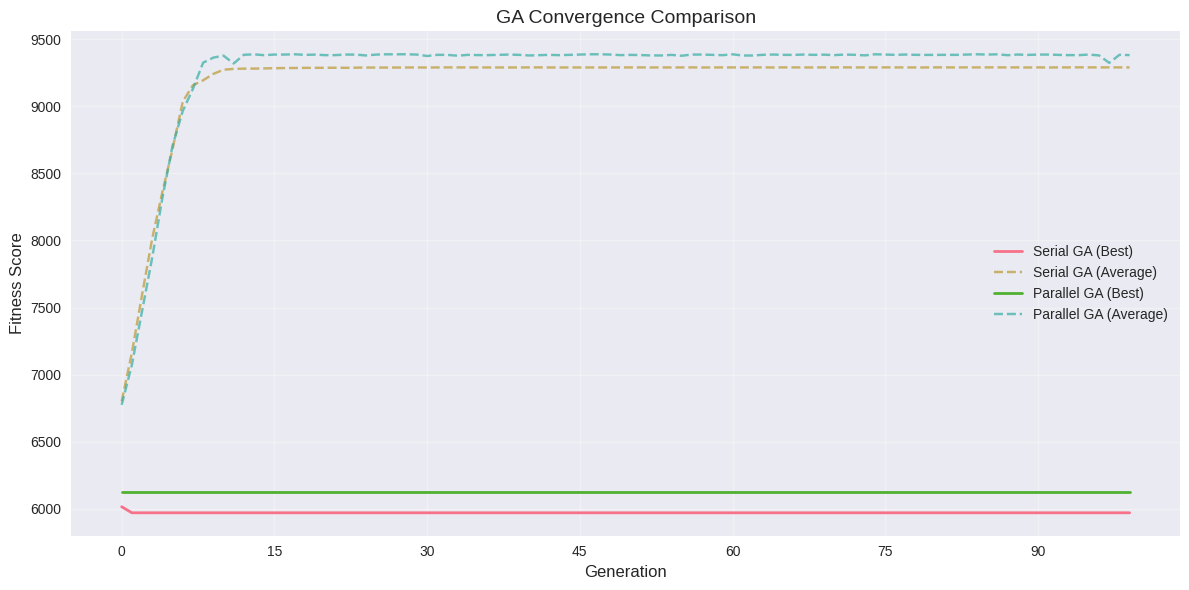

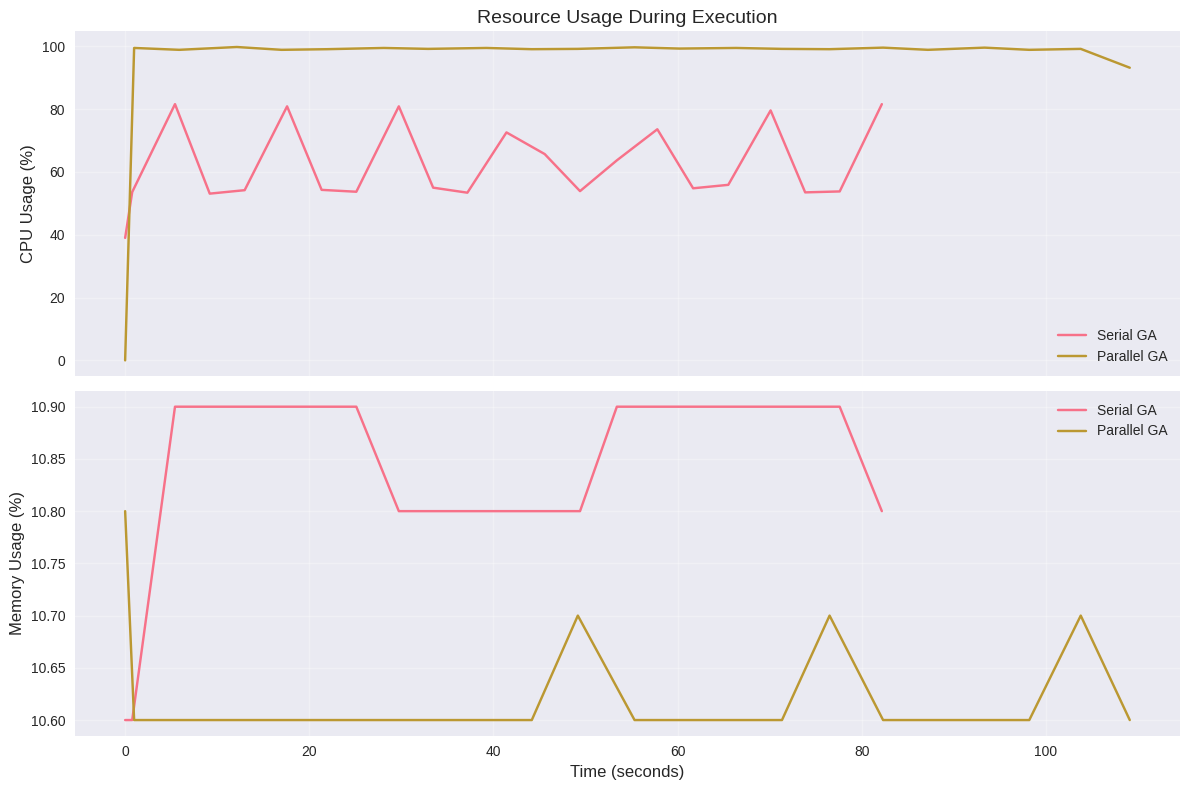

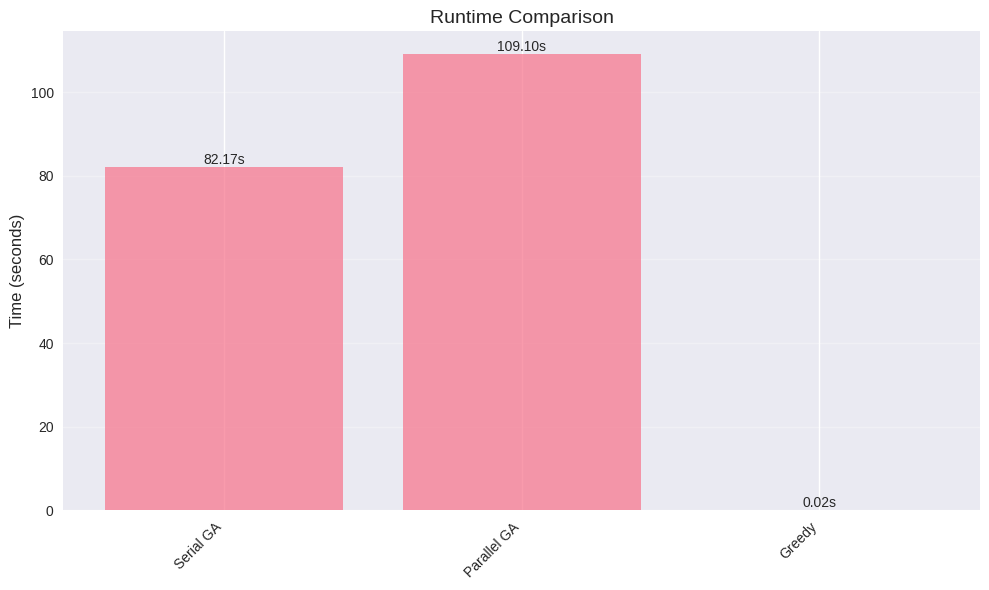

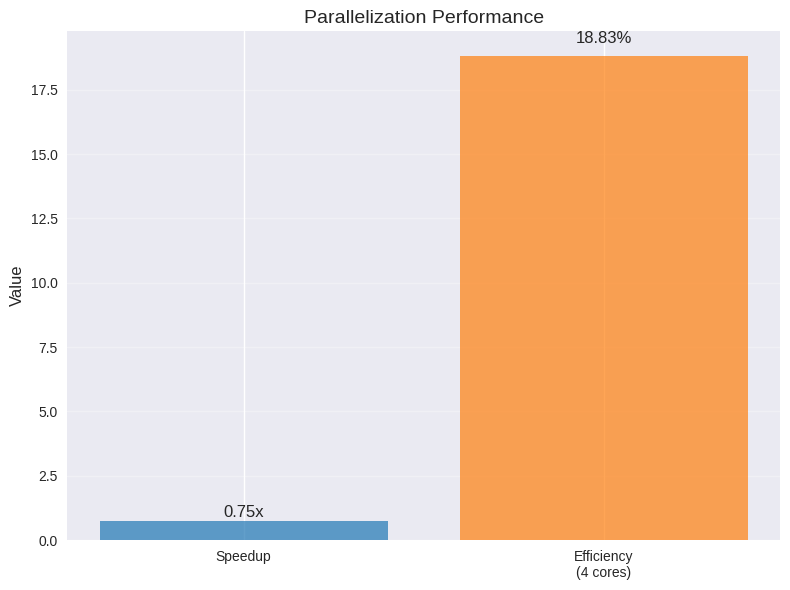

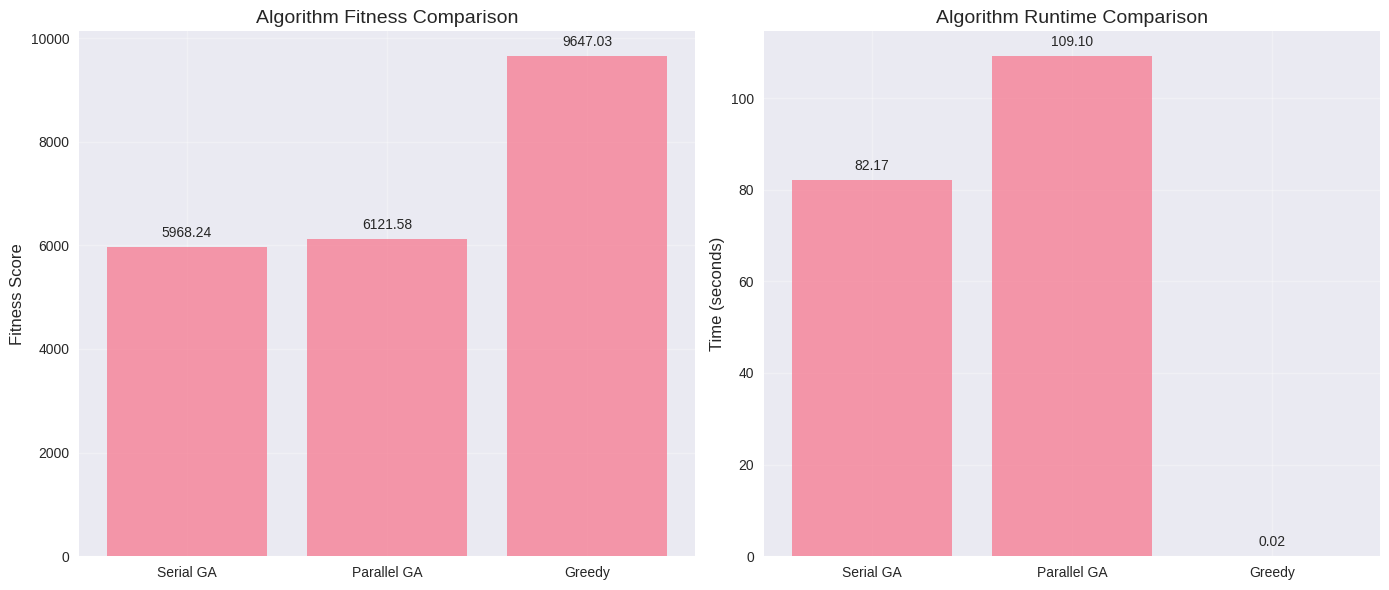


Best energy allocation matrix from Parallel GA:
       Node_1  Node_2  Node_3  Node_4  Node_5  Node_6  Node_7  Node_8  Node_9  \
Solar   43.67   63.80   93.62    7.07   88.76   59.60   69.73   44.40   41.46   
Wind    90.81   68.49   98.04   41.29   35.16   81.70   53.70   33.42   85.82   
Hydro   70.72   79.68   69.45   32.39   33.51   66.66   18.47   79.54   18.37   

       Node_10  
Solar    88.54  
Wind     91.71  
Hydro    14.75  


In [156]:
def comprehensive_comparison(hour=0):
    """Run comprehensive comparison with all visualizations"""
    print(f"Running comprehensive comparison for hour {hour}...\n")

    # Run algorithms with monitoring
    print("Running Serial GA...")
    serial_result = run_ga_with_monitoring(hour, parallel=False)

    print("\nRunning Parallel GA...")
    parallel_result = run_ga_with_monitoring(hour, parallel=True)

    print("\nRunning Greedy Algorithm...")
    start_time = timeit.default_timer()
    greedy_solution, greedy_fitness = run_greedy_for_hour(hour)
    greedy_time = timeit.default_timer() - start_time

    # Prepare results dictionary
    results = {
        'Serial GA': {
            'solution': serial_result['solution'],
            'fitness': serial_result['fitness'],
            'time': serial_result['monitor'].get_stats()['duration'],
            'history': serial_result['history'],
            'monitor': serial_result['monitor']
        },
        'Parallel GA': {
            'solution': parallel_result['solution'],
            'fitness': parallel_result['fitness'],
            'time': parallel_result['monitor'].get_stats()['duration'],
            'history': parallel_result['history'],
            'monitor': parallel_result['monitor']
        },
        'Greedy': {
            'solution': greedy_solution,
            'fitness': greedy_fitness,
            'time': greedy_time,
            'history': None,
            'monitor': None
        }
    }

    # Print summary statistics
    print("\n=== Algorithm Performance Summary ===")
    for alg, data in results.items():
        print(f"\n{alg}:")
        print(f"  Fitness: {data['fitness']:.2f}")
        print(f"  Runtime: {data['time']:.2f}s")
        if alg != 'Greedy':
            stats = data['monitor'].get_stats()
            print(f"  Max CPU: {stats['max_cpu']:.1f}%")
            print(f"  Avg CPU: {stats['avg_cpu']:.1f}%")
            print(f"  Max Memory: {stats['max_memory']:.1f}%")

    # Generate all visualizations
    print("\nGenerating visualizations...")

    # 1. Convergence plots
    plot_convergence(
        [results['Serial GA']['history'], results['Parallel GA']['history']],
        ['Serial GA', 'Parallel GA'],
        "GA Convergence Comparison"
    )

    # 2. Resource usage
    plot_resource_usage(
        [results['Serial GA']['monitor'], results['Parallel GA']['monitor']],
        ['Serial GA', 'Parallel GA']
    )

    # 3. Runtime comparison
    plot_runtime_stats({
        'Serial GA': results['Serial GA']['time'],
        'Parallel GA': results['Parallel GA']['time'],
        'Greedy': results['Greedy']['time']
    })

    # 4. Speedup and efficiency
    plot_speedup_efficiency(
        results['Serial GA']['time'],
        results['Parallel GA']['time'],
        N_CORES
    )

    # 5. Algorithm comparison
    plot_algorithm_comparison({
        'Serial GA': results['Serial GA'],
        'Parallel GA': results['Parallel GA'],
        'Greedy': results['Greedy']
    })

    return results

if __name__ == "__main__":
    # Run comprehensive comparison
    results = comprehensive_comparison(hour=0)

    # Display the best allocation matrix from parallel GA
    print("\nBest energy allocation matrix from Parallel GA:")
    allocation_df = pd.DataFrame(
        results['Parallel GA']['solution'],
        index=sources,
        columns=[f'Node_{i+1}' for i in range(len(nodes))]
    )
    print(allocation_df.round(2))

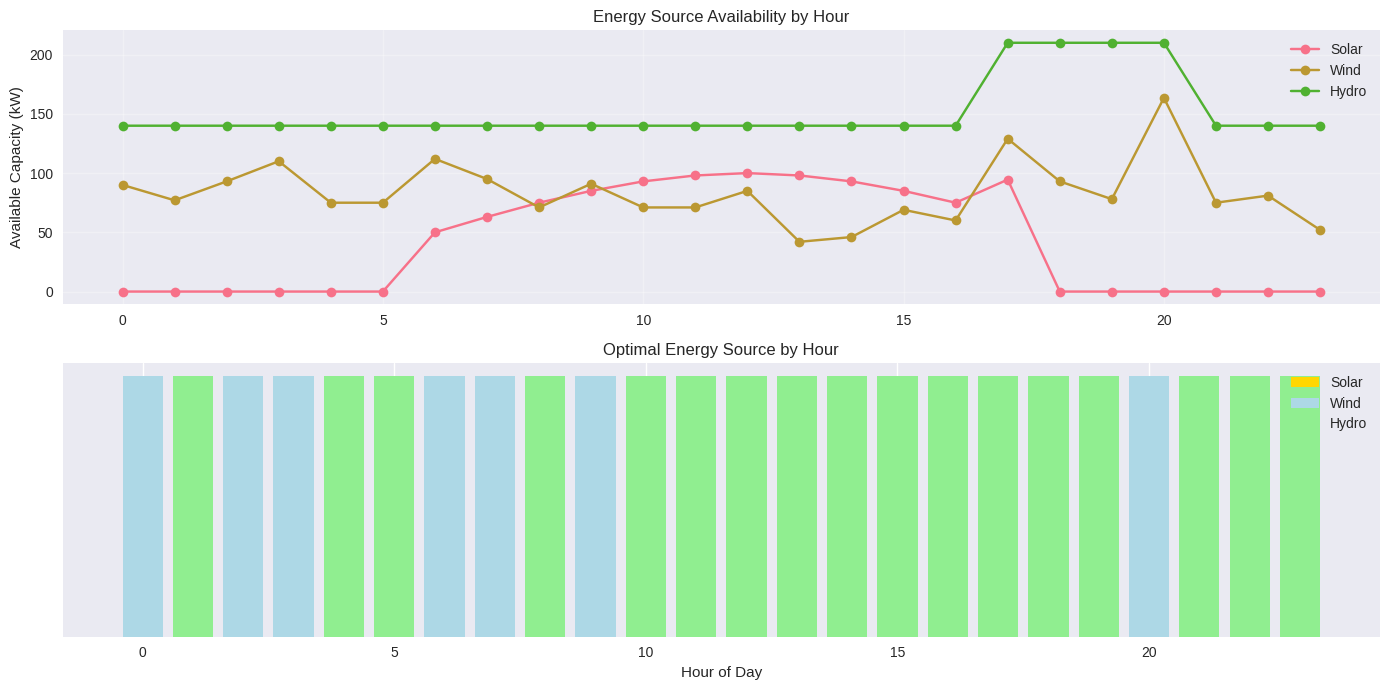


Best energy source for each hour:
    Hour Best_Source
0      0        Wind
1      1       Hydro
2      2        Wind
3      3        Wind
4      4       Hydro
5      5       Hydro
6      6        Wind
7      7        Wind
8      8       Hydro
9      9        Wind
10    10       Hydro
11    11       Hydro
12    12       Hydro
13    13       Hydro
14    14       Hydro
15    15       Hydro
16    16       Hydro
17    17       Hydro
18    18       Hydro
19    19       Hydro
20    20        Wind
21    21       Hydro
22    22       Hydro
23    23       Hydro


In [157]:
def analyze_best_source_over_hours():
    """Analyzes the best energy source for each hour based on cost and availability"""
    hours = generation_df['Hour'].unique()
    best_sources = []

    for hour in hours:
        # Get generation data for the hour
        gen_data = generation_df[generation_df['Hour'] == hour].iloc[0]
        peak_multiplier = gen_data['Peak_Multiplier']

        # Calculate effective generation capacity (adjusted by peak multiplier)
        solar_cap = gen_data['Solar'] * peak_multiplier
        wind_cap = gen_data['Wind'] * peak_multiplier
        hydro_cap = gen_data['Hydro'] * peak_multiplier

        # Get costs
        solar_cost = cost_df.loc[cost_df['Source'] == 'Solar', 'Generation_Cost_per_kWh'].values[0]
        wind_cost = cost_df.loc[cost_df['Source'] == 'Wind', 'Generation_Cost_per_kWh'].values[0]
        hydro_cost = cost_df.loc[cost_df['Source'] == 'Hydro', 'Generation_Cost_per_kWh'].values[0]

        # Calculate cost per available kW
        solar_cost_per_kw = solar_cost / solar_cap if solar_cap > 0 else float('inf')
        wind_cost_per_kw = wind_cost / wind_cap if wind_cap > 0 else float('inf')
        hydro_cost_per_kw = hydro_cost / hydro_cap if hydro_cap > 0 else float('inf')

        # Determine best source (lowest cost per available kW)
        costs = {
            'Solar': solar_cost_per_kw,
            'Wind': wind_cost_per_kw,
            'Hydro': hydro_cost_per_kw
        }

        best_source = min(costs, key=costs.get)
        best_sources.append({
            'Hour': hour,
            'Best_Source': best_source,
            'Solar_Capacity': solar_cap,
            'Wind_Capacity': wind_cap,
            'Hydro_Capacity': hydro_cap,
            'Solar_Cost': solar_cost,
            'Wind_Cost': wind_cost,
            'Hydro_Cost': hydro_cost
        })

    # Convert to DataFrame
    best_sources_df = pd.DataFrame(best_sources)

    # Plot the results
    plt.figure(figsize=(14, 7))

    # Plot capacities
    plt.subplot(2, 1, 1)
    plt.plot(hours, best_sources_df['Solar_Capacity'], label='Solar', marker='o')
    plt.plot(hours, best_sources_df['Wind_Capacity'], label='Wind', marker='o')
    plt.plot(hours, best_sources_df['Hydro_Capacity'], label='Hydro', marker='o')
    plt.ylabel('Available Capacity (kW)')
    plt.title('Energy Source Availability by Hour')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot best sources
    plt.subplot(2, 1, 2)
    colors = []
    for source in best_sources_df['Best_Source']:
        if source == 'Solar':
            colors.append('gold')
        elif source == 'Wind':
            colors.append('lightblue')
        else:
            colors.append('lightgreen')

    plt.bar(hours, height=1, width=0.8, color=colors)
    plt.yticks([])
    plt.xlabel('Hour of Day')
    plt.title('Optimal Energy Source by Hour')

    # Create legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='gold', label='Solar'),
        Patch(facecolor='lightblue', label='Wind'),
        Patch(facecolor='lightgreen', label='Hydro')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

    return best_sources_df

# Run the analysis
best_sources_24h = analyze_best_source_over_hours()
print("\nBest energy source for each hour:")
print(best_sources_24h[['Hour', 'Best_Source']])